In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import numpy as np
import datetime

### Wczytywanie danych 

In [121]:
df = pd.read_csv('D:/Projektiki/Dannyje/hotel_booking.csv')

In [122]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [124]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [125]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

children         4
country        488
agent        16340
company     112593
dtype: int64


Przyjrzyjmy się również procentowi brakujących wartości

In [126]:
missing_percentage = df.isnull().mean() * 100
print(missing_percentage[missing_percentage > 0])


children     0.003350
country      0.408744
agent       13.686238
company     94.306893
dtype: float64


### Analiza pierwotnych danych oraz ich przygotowanie
Dane zawierają 36 kolumn i 119390 wpisów

* `hotel` -- typ hotelu;
* `is_canceled` -- status anulowania (atrybut docelowy);
* `lead_time` -- czas przed przyjazdem;
* `arrival_date_year`, `arrival_date_month`, `arrival_date_week_number`, `arrival_date_day_of_month` -- data przyjazdu;
* `stays_in_weekend_nights`, `stays_in_week_nights` -- liczba noclegów w weekendy i dni powszednie;
* `adults`, `children`, `babies` -- liczba osób dorosłych, dzieci i niemowląt;
* `meal` -- rodzaj posiłku;
* `country` --  kraj klienta;
* `market_segment` -- segment rynku;
* `distribution_channel` -- kanał dystrybucji;
* `is_repeated_guest` -- stały klient;
* `previous_cancellations`, `previous_bookings_not_cancled` -- liczba wcześniejszych anulowanych i nieodwołanych rezerwacji;
* `reserved_room_type`, `assigned_room_type` -- typ zarezerwowanego i przydzielonego pokoju;
* `booking_changes` -- liczba zmian rezerwacji;
* `deposit_type` -- typ depozytu;
* `agent`, `company` -- identyfikatory agenta i firmy;
* `days_in_waiting_list` -- liczba dni na liście oczekujących;
* `customer_type` -- typ klienta;
* `adr` -- średnia stawka dzienna;
* `required_car_parking_spaces` -- liczba wymaganych miejsc parkingowych;
* `total_of_special_requests` -- całkowita liczba zamówień specjalnych;
* `reservation_status`, `reservation_status_date` -- status rezerwacji i data statusu;

##### W niektórych kolumnach istnieją brakujące wartości
`children`, `country`, `agent`, `company` trzeba dopełnić brakujące wartości

##### Ponadto, aby uprościć proces pracy z danymi, można usunąć niepotrzebne kolumny:
`name`, `email`, `phone-number`, `credit_card`



In [127]:
df['children'].fillna(0, inplace=True)
df['country'].fillna('Unknown', inplace=True)
df['agent'].fillna(0, inplace=True)
df['company'].fillna(0, inplace=True)

df = df.drop(columns=['name', 'email', 'phone-number', 'credit_card'])

C:\Users\Rodion\AppData\Local\Temp\ipykernel_14476\417846356.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['children'].fillna(0, inplace=True)
C:\Users\Rodion\AppData\Local\Temp\ipykernel_14476\417846356.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

Sprawdźmy, czy nie ma duplikatów.

In [128]:
len(df[df.duplicated()])

31994

Usuniemy duplikaty

In [129]:
df = df.drop_duplicates()

In [130]:
df['is_canceled'] = df['is_canceled'].astype(bool)
df['is_repeated_guest'] = df['is_repeated_guest'].astype(bool)

Konwertowanie nazw miesięcy na wartości liczbowe

In [131]:
df['arrival_date_month'] = df['arrival_date_month'].map({'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12})
     

In [132]:
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

Zmienimy typ danych dla kolumny `children`

In [133]:
df[['children']] = df[['children']].astype('int')

### EDA

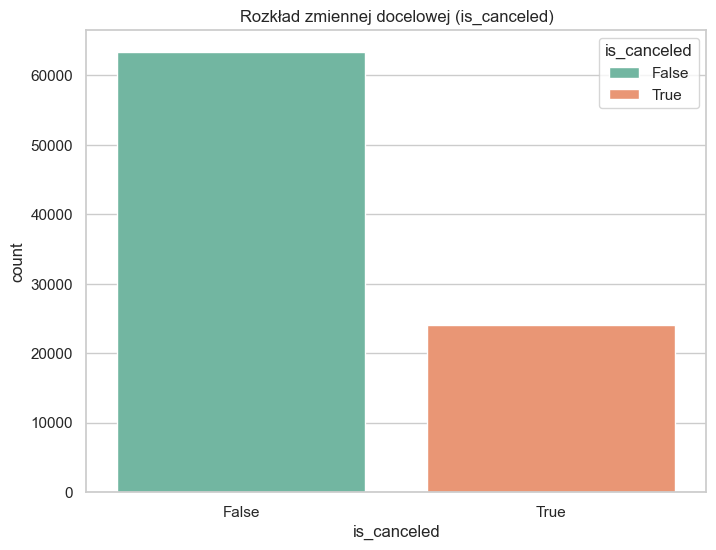

Procent anulowanych rezerwacji: 27.49%


In [134]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_canceled', hue='is_canceled', data=df, palette="Set2")
plt.title('Rozkład zmiennej docelowej (is_canceled)')
plt.show()

cancel_rate = df['is_canceled'].mean() * 100
print(f"Procent anulowanych rezerwacji: {cancel_rate:.2f}%")

Widzimy wyraźny brak równowagi klas w kolumnie `is_canceled` 

*Przyjrzyjmy się rezerwacjom w różnych typach hoteli*

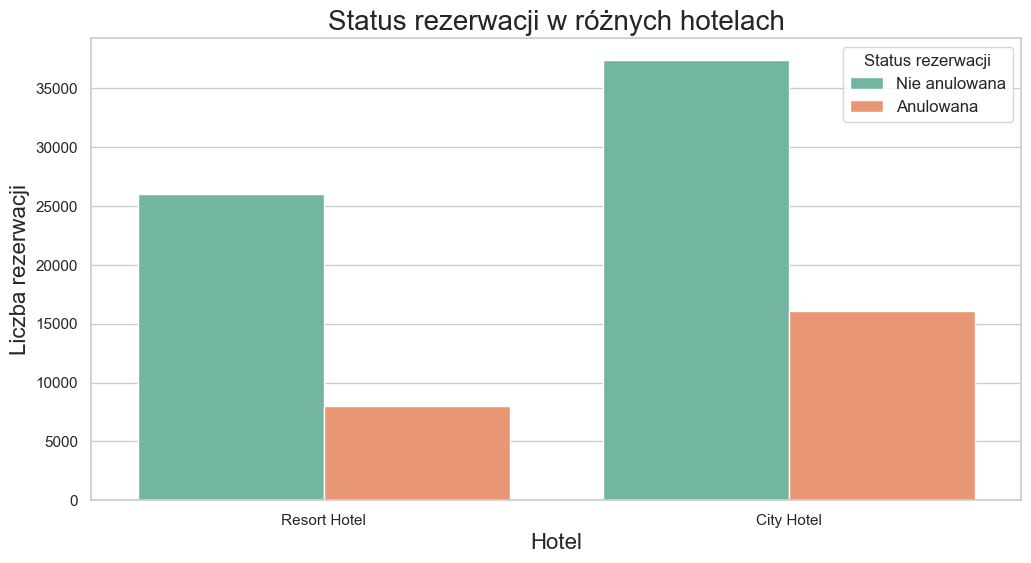

In [135]:
plt.figure(figsize=(12, 6))  

ax1 = sns.countplot(x='hotel', hue='is_canceled', data=df, palette="Set2")

ax1.legend(bbox_to_anchor=(1, 1), title="Status rezerwacji")

plt.title('Status rezerwacji w różnych hotelach', size=20)
plt.xlabel('Hotel', fontsize=16)
plt.ylabel('Liczba rezerwacji', fontsize=16)
plt.legend(['Nie anulowanа', 'Anulowana'], title='Status rezerwacji', fontsize=12)
plt.show()

================================

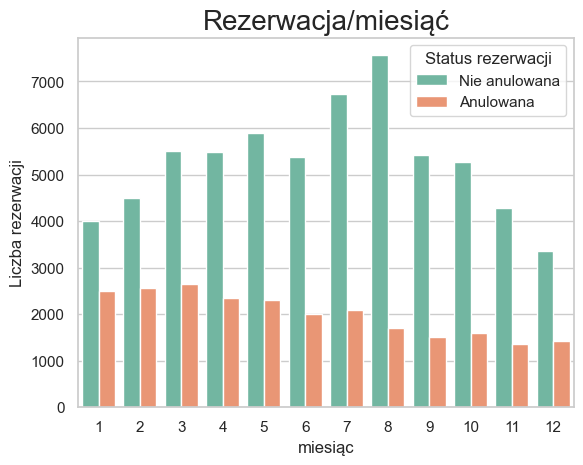

In [136]:
df['month']=df['reservation_status_date'].dt.month
ax1 = sns.countplot(x='month', hue='is_canceled', data= df, palette = 'Set2')
legend_lebels,_ = ax1.get_legend_handles_labels()
plt.title('Rezerwacja/miesiąć', size = 20)
plt.xlabel('miesiąc')
plt.ylabel('Liczba rezerwacji')
plt.legend(['Nie anulowanа','Anulowana'], title='Status rezerwacji')
plt.show()

#### Macierz korelacji cech numerycznych

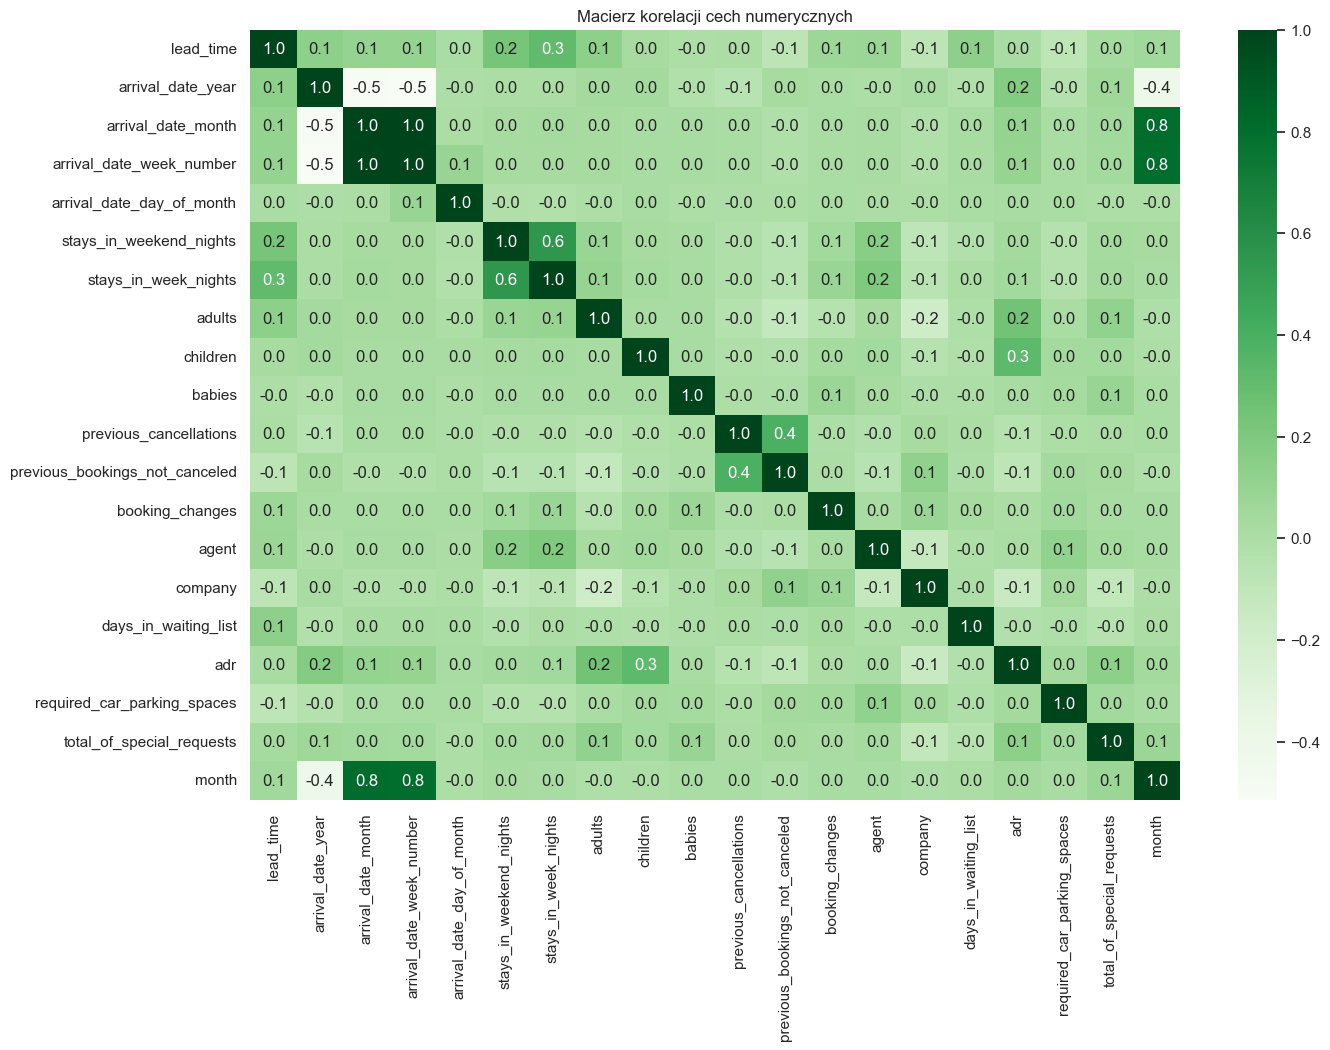

In [137]:
numeric_df = df.select_dtypes(include='number')
corr_matrix = numeric_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap="Greens", annot=True, fmt=".1f")
plt.title('Macierz korelacji cech numerycznych')
plt.show()

================================

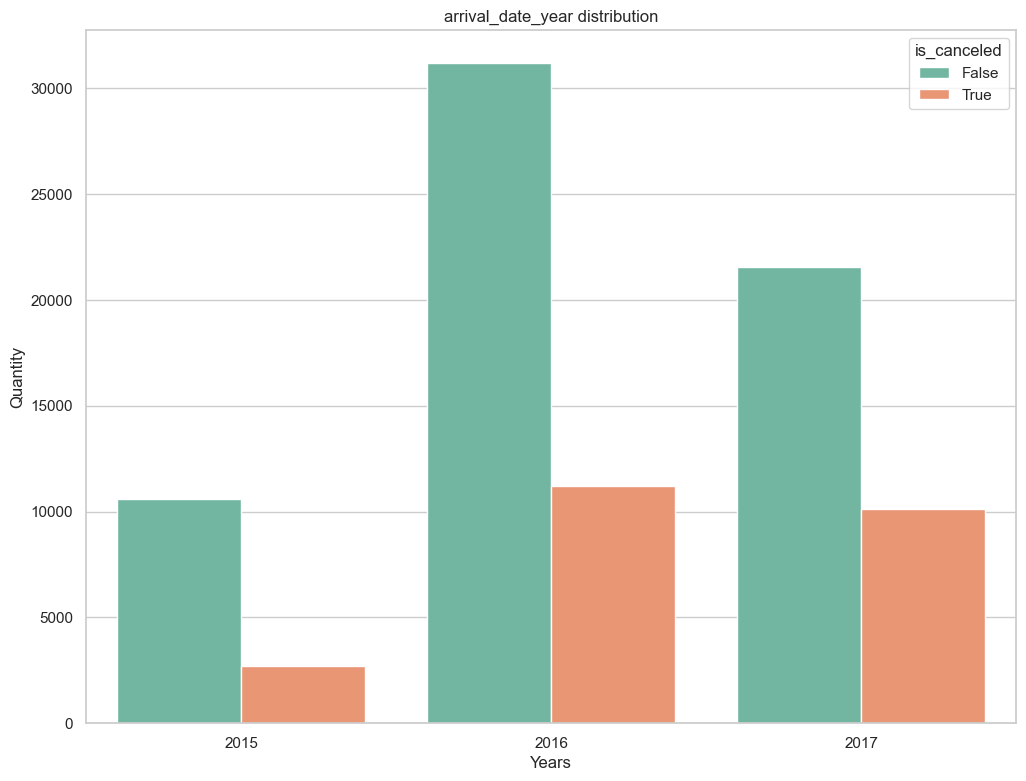

In [138]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 9))
sns.countplot(x='arrival_date_year', hue='is_canceled', data=df, palette = 'Set2')

plt.title('arrival_date_year distribution')
plt.xlabel('Years')
plt.ylabel('Quantity')

plt.show()

In [139]:
print(df['adults'].value_counts())
print(df['children'].value_counts()) 
print(df['babies'].value_counts())

adults
2     64497
1     16503
3      5935
0       385
4        60
26        5
5         2
27        2
20        2
40        1
55        1
50        1
6         1
10        1
Name: count, dtype: int64
children
0     79032
1      4695
2      3593
3        75
10        1
Name: count, dtype: int64
babies
0     86482
1       897
2        15
10        1
9         1
Name: count, dtype: int64


Najczęściej rezerwowany jest pokój dla 2 osób dorosłych.

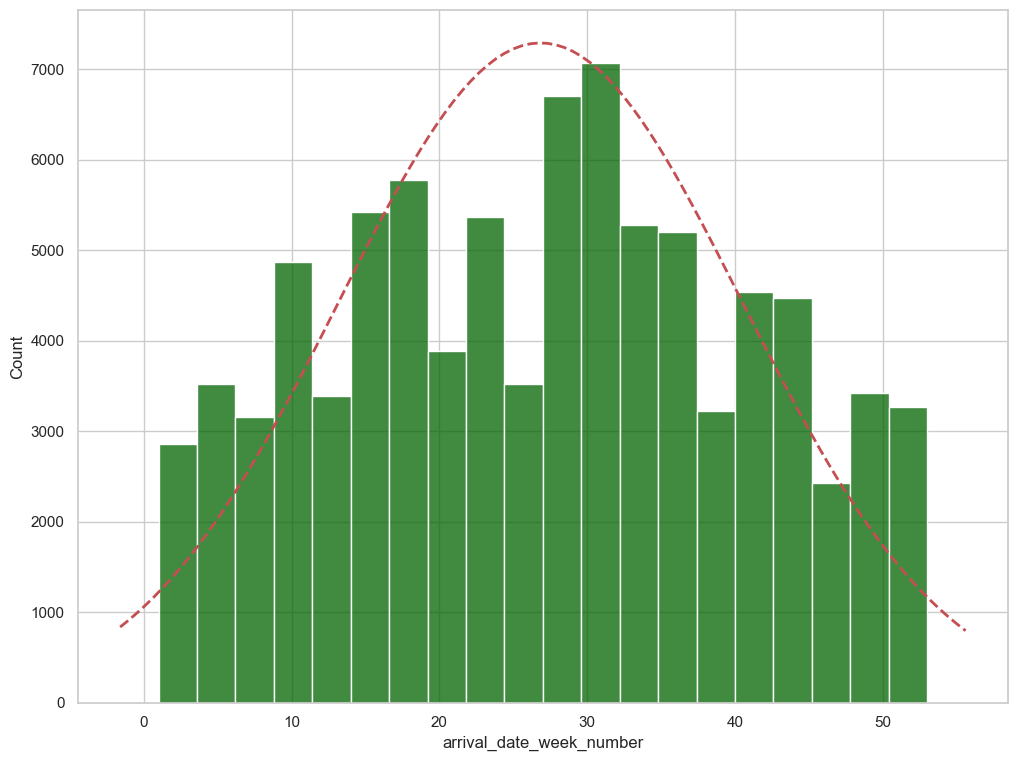

In [140]:
mu = df['arrival_date_week_number'].mean()
std = df['arrival_date_week_number'].std()

plt.figure(figsize=(12, 9))
sns.histplot(df['arrival_date_week_number'], bins=20, color='darkgreen', kde=False)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p * len(df['arrival_date_week_number']) * (xmax - xmin) / 20, 'r--', linewidth=2)

plt.show()


Dane w kolumnie `arrival_date_week_number` mają prawie normalny rozkład.

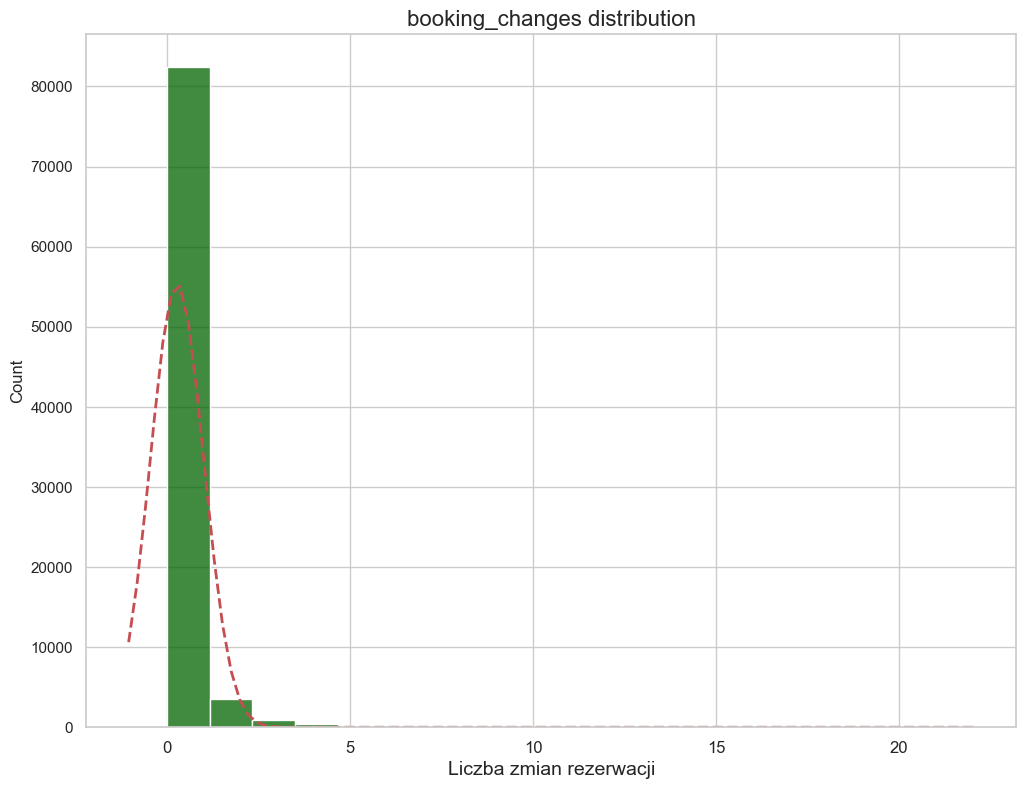

In [141]:
mu = df['booking_changes'].mean()
std = df['booking_changes'].std()

# Построить гистограмму данных
plt.figure(figsize=(12, 9))
sns.histplot(df['booking_changes'], color='darkgreen', kde=False)

# Добавить нормальное распределение
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p * len(df['booking_changes']) * (xmax - xmin) / 20, 'r--', linewidth=2)


plt.title('booking_changes distribution', fontsize=16)
plt.xlabel('Liczba zmian rezerwacji', fontsize=14)
plt.xticks(fontsize=12)
plt.grid(True)

plt.show()


W kolumnie `booking_changes` widzimy rozkład wykładniczy

##### Analiza krajów przybycia 
Istnieje wiele krajów z niewielką liczbą odwiedzin w kolumnie `country`, więc zachowajmy 12 krajów i przypiszmy wartość "inne" pozostałym.

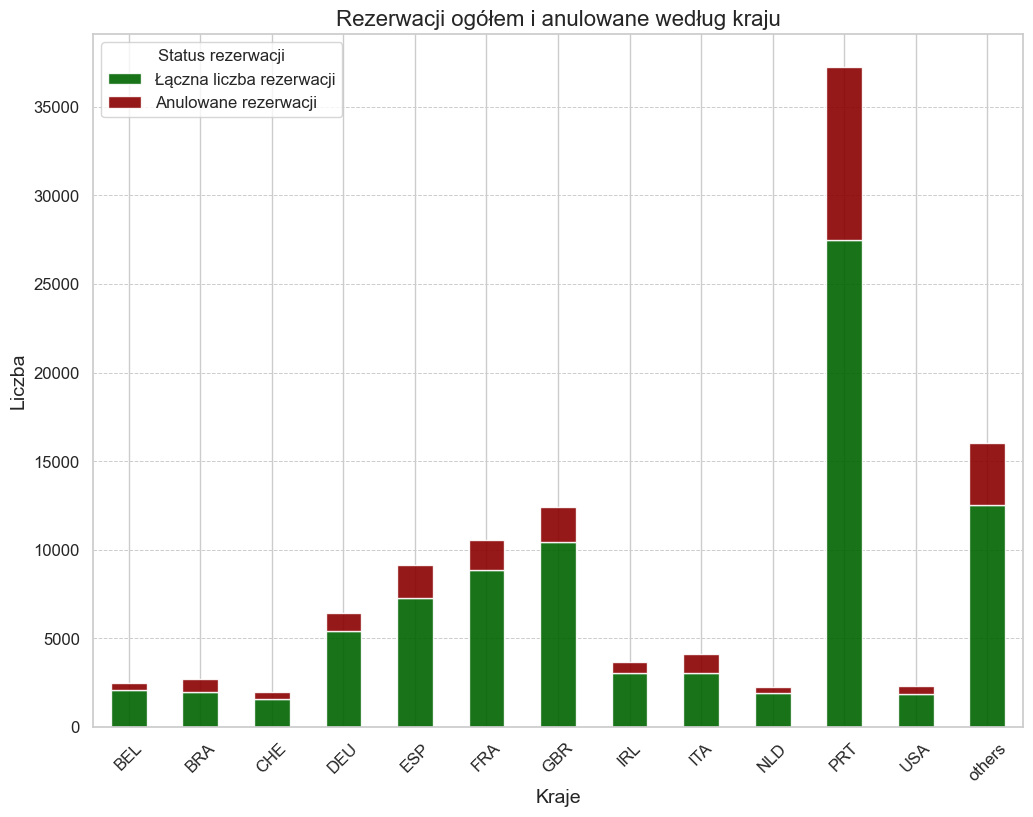

In [142]:
countries = ['PRT', 'FRA', 'GBR', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'NLD', 'USA', 'CHE']
df['country'] = df['country'].apply(lambda x: 'others' if x not in countries else x)


total_orders = df['country'].value_counts()
canceled_orders = df[df['is_canceled'] == 1]['country'].value_counts()


df_stacked = pd.DataFrame({
    'Łączna liczba rezerwacji': total_orders,
    'Anulowane rezerwacji': canceled_orders
}).fillna(0)


df_stacked.plot(kind='bar', stacked=True, figsize=(12, 9), color=['darkgreen', 'darkred'], alpha=0.9)
plt.title('Rezerwacji ogółem i anulowane według kraju', fontsize=16)
plt.xlabel('Kraje', fontsize=14)
plt.ylabel('Liczba', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Status rezerwacji', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

plt.show()

Widać, że więcej rezerwacji pochodzi od klientów z Portugalii. Dlatego więcej anulowanych rezerwacji również pochodzi od portugalskich klientów.